In [2]:
import torch
from torch import nn, tanh
import numpy as np
from torch.autograd import grad
from torch.utils.data import DataLoader
import h5py
import gc
import time
from IPython.display import clear_output
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

In [3]:
rng = np.random.default_rng(52)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
with h5py.File('../observations.hf','r') as data:
    train_data = data['ob5'][:]
    a1_actual, a2_actual = train_data[0, [2, 3]]
    print(a1_actual, a2_actual)
    batch_size = 256
    rng.shuffle(train_data)
    
    train_data = train_data[:]
    x_mean, x_std = (0.0, np.sqrt(1/3))
    train_x = (train_data[:, [0]] - x_mean)/x_std
    train_x = DataLoader(train_x, batch_size = batch_size, drop_last = True)

    t_mean, t_std = (0.5, np.sqrt(1/12))
    train_t = (train_data[:, [1]] - t_mean)/t_std
    train_t = DataLoader(train_t, batch_size = batch_size, drop_last = True)
    
    train_u = DataLoader(train_data[:, [4]], batch_size = batch_size, drop_last = True)
    train_data = None
    print(len(train_x))

0.0001 5.0
39


In [9]:
a1_mean, a1_std = (1e-4 + 1e-1)/2, np.sqrt(np.square((1e-4 - 1e-1))/12)
a2_mean, a2_std = (1.0 + 10.0)/2, np.sqrt(np.square((1.0 - 10.0))/12)

In [40]:
class MyModel(nn.Module):
    def __init__(self, width, depth, batch_size):
        super(MyModel, self).__init__()
        self.epoch = 0
        self.batch_size = batch_size
        self.train_losses = []
        self.log_losses = []
        self.valid_losses = []
        self.log_valid_losses = []
        self.durations = []
        self.a1s = []
        self.a2s = []
        self.layers1 = nn.ModuleList()
        
        for i in range(depth):
            if i == 0:
                in1, out1 = 4, width
            elif i == depth - 1:
                in1, out1 = width, 1
            else:
                in1 = out1 = width
            self.layers1.append(nn.Linear(in1, out1).double())
            nn.init.xavier_uniform_(self.layers1[i].weight)
            nn.init.zeros_(self.layers1[i].bias)
    
    def forward(self, x, t, a1, a2):
        inputs_1 = torch.cat([x, t, a1.repeat(x.shape[0], 1), a2.repeat(x.shape[0], 1)], axis = 1)
        for i in range(len(self.layers1) - 1):
            inputs_1 = tanh(self.layers1[i](inputs_1))
        inputs_1 = self.layers1[-1](inputs_1)
        return inputs_1

    def pde_loss_fn(self, x, t, a1, a2, u):
        du_dx = grad(u, x, grad_outputs = self.ones, create_graph = True, retain_graph = True)[0]
        d2u_dx2 = grad(du_dx, x, grad_outputs = self.ones, create_graph = True, retain_graph = True)[0]
        du_dt = grad(u, t, grad_outputs = self.ones, create_graph = True, retain_graph = True)[0]
        pde = (du_dt/t_std - (a1_mean + a1 * a1_std) * d2u_dx2 * 1/(x_std ** 2) + (a2_mean + a2 * a2_std) * (u ** 3 - u)) ** 2
        return pde.mean()

    def start_training(self, max_epoch, validate, optimizer, make_plot, a1, a2):
        self.optimizer = optimizer
        self.max_epoch = max_epoch
        self.validate = validate
        self.make_plot = make_plot
        
        if self.make_plot:
            fig = plt.figure()
            gs = gridspec.GridSpec(2, 2)
            ax1 = plt.subplot(gs[0, :])
            ax2 = plt.subplot(gs[1, 0])
            ax3 = plt.subplot(gs[1, 1])

        loss_fn = nn.MSELoss()
        zeros = torch.zeros((self.batch_size, 1), dtype = torch.double, device = device)
        self.ones = torch.ones_like(zeros)
        
        while (self.epoch < self.max_epoch):
            
            start = time.time()
            self.epoch += 1
            
            for x, t, u in zip(train_x, train_t, train_u):                
                
                for param in self.parameters():
                    param.grad = None
                
                x = x.requires_grad_(True).to(device)
                t = t.requires_grad_(True).to(device)
                u = u.to(device)
                u_ic = (x_mean + x * x_std) ** 2 * torch.cos(np.pi * (x_mean + x * x_std))

                u_hat = self(x, t, a1, a2)
                u_ic_hat = self(x, (zeros - t_mean)/t_std, a1, a2)
                
                loss = loss_fn(u_hat, u) 
                loss += loss_fn(u_ic_hat, u_ic)
                loss += self.pde_loss_fn(x, t, a1, a2, u_hat)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                optimizer.step()
                
            self.train_losses.append(loss.item())
            self.log_losses.append(torch.log10(loss).item())
            self.a1s.append(a1_mean + a1.item() * a1_std)
            self.a2s.append(a2_mean + a2.item() * a2_std)
        
            stop = time.time()
            duration = stop - start
            self.durations.append(duration)

            clear_output(wait = True)
            print(f"Train epoch: {self.epoch}, loss: {self.train_losses[-1]:.2e}, duration: {duration:.2e}")
            print(f"a1_output: {a1_mean + a1.item() * a1_std:.2e}, a2_output: {a2_mean + a2.item() * a2_std:.2e}")
            print(f"a1_actual: {a1_actual:.2e}, a2_actual: {a2_actual:.2e}")
            
            if self.make_plot:
                ax1 = plt.subplot(gs[0, :])
                ax2 = plt.subplot(gs[1, 0])
                ax3 = plt.subplot(gs[1, 1])
                
                ax1.set_xlabel("epoch")
                ax1.set_ylabel("log-loss")
                ax1.set_title("log-loss vs epoch")

                ax2.set_xlabel("epoch")
                ax2.set_ylabel("value")
                ax2.set_title("a1 vs epoch")

                ax3.set_xlabel("epoch")
                ax3.set_ylabel("value")
                ax3.set_title("a2 vs epoch")

                ax1.plot(self.log_losses, label = "log-loss")
                ax2.plot(self.a1s, label = "a1")
                ax2.plot([0, self.epoch], [a1_actual, a1_actual], label = "a1_actual", linestyle = "--", color = "r")
                ax3.plot(self.a2s, label = "a2")
                ax3.plot( [0, self.epoch], [a2_actual, a2_actual], label = "a2_actual", linestyle = "--", color = "r")

                plt.tight_layout()
                plt.legend()
                plt.show()

In [41]:
model = MyModel(30, 30, batch_size).to(device)
a1 = nn.Parameter(torch.Tensor([[0.0]]).to(device).double(), requires_grad = True)
a2 = nn.Parameter(torch.Tensor([[0.0]]).to(device).double(), requires_grad = True)

param_groups = [
    {'name': 'a1', 'params': a1, 'lr': 1e-4, 'weight_decay': 1e-4},
    {'name': 'a2', 'params': a2, 'lr': 1e-3, 'weight_decay': 1e-4},
    {'name': 'model', 'params': [param for _, param in model.named_parameters()], 'lr': 1e-4, 'weight_decay': 1e-4}
]

make_plot = True
max_epoch = 50000
validate = False
optimizer = torch.optim.Adam(param_groups)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.99)

Train epoch: 322, loss: 9.89e-03, duration: 3.32e+00
a1_output: 8.54e-03, a2_output: 5.41e+00
a1_actual: 1.00e-04, a2_actual: 5.00e+00


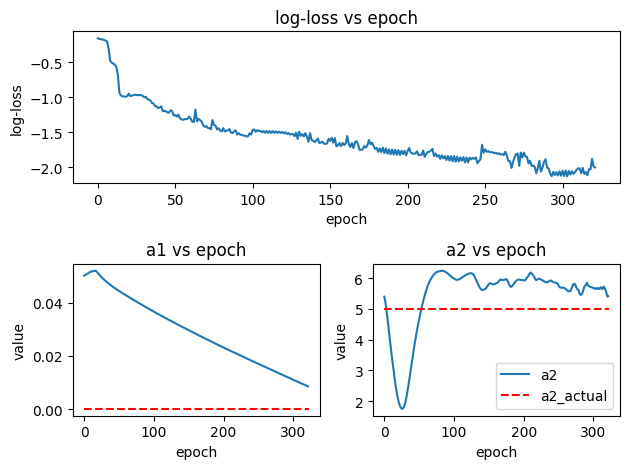

Training paused.


102667

In [42]:
try:
    model.start_training(max_epoch, validate, optimizer, make_plot, a1, a2)
except KeyboardInterrupt:
    print("Training paused.")
gc.collect()

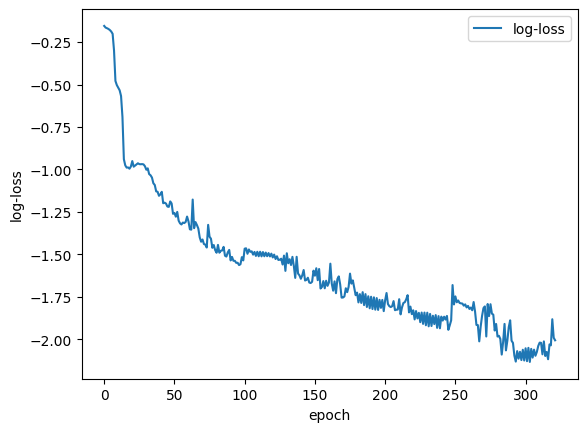

In [43]:
g = plt.plot(model.log_losses, label = 'log-loss')
g = plt.xlabel("epoch")
g = plt.ylabel("log-loss")
g = plt.legend()

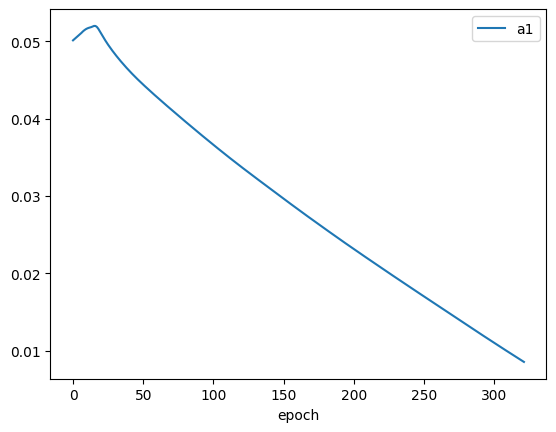

In [44]:
g = plt.plot(model.a1s, label = 'a1')
g = plt.xlabel("epoch")
g = plt.legend()

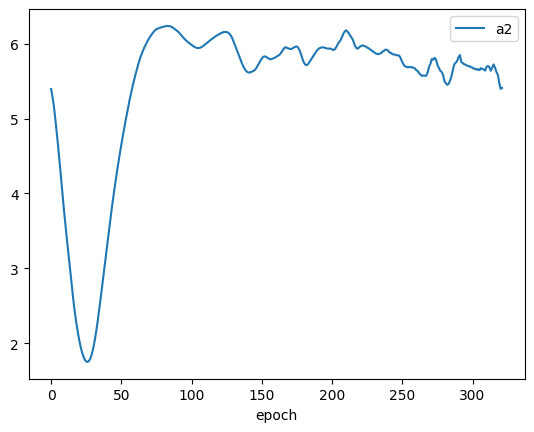

In [45]:
g = plt.plot(model.a2s, label = 'a2')
g = plt.xlabel("epoch")
g = plt.legend()

In [46]:
with h5py.File('../observations.hf', 'r') as file:
    ob = file['ob5']
    ob_x = torch.from_numpy(ob[:, [0]])
    ob_x_norm = (ob_x - x_mean)/x_std
    ob_t = torch.from_numpy(ob[:, [1]])
    ob_t_norm = (ob_t - t_mean)/t_std
    ob_u = torch.from_numpy(ob[:, [4]])
    print(ob[0, [2, 3]])

[1.e-04 5.e+00]


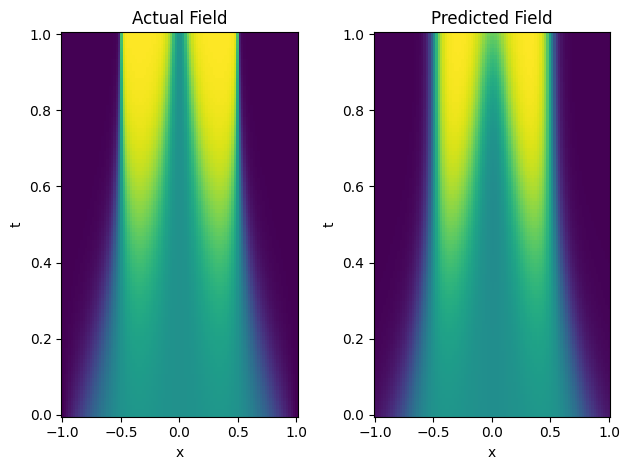

In [47]:
N = 100
x = ob_x.reshape(N, N)
t = ob_t.reshape(N, N)
g = plt.figure()
g = plt.subplot(1, 2, 1)
g = plt.pcolormesh(x, t, ob_u.reshape(N, N))
g = plt.title('Actual Field')
g = plt.xlabel('x')
g = plt.ylabel('t')
g = plt.subplot(1, 2, 2)
with torch.no_grad():
    out = model.forward(ob_x_norm.to(device), ob_t_norm.to(device), a1, a2).to('cpu')
g = plt.pcolormesh(x, t, out.reshape(N, N))
g = plt.title('Predicted Field')
g = plt.xlabel('x')
g = plt.ylabel('t')
g = plt.tight_layout()

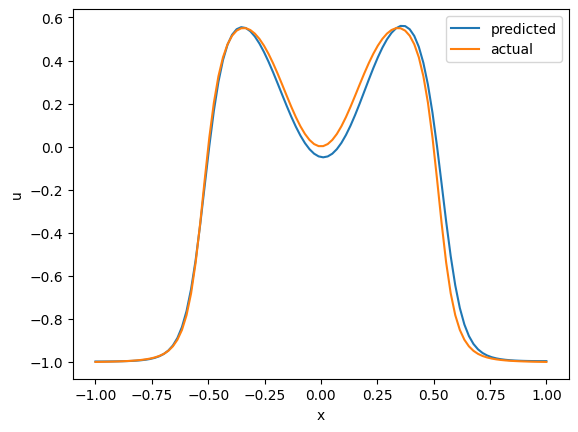

In [48]:
# Time slices between 1 and N
k = 50
g = plt.plot(ob_x[(k - 1) * N:k * N, 0], out[(k - 1) * N:k * N], label = 'predicted')
g = plt.plot(ob_x[(k - 1) * N:k * N, 0], ob_u[(k - 1) * N:k * N], label = 'actual')
g = plt.xlabel('x')
g = plt.ylabel('u')
g = plt.legend()

In [140]:
torch.save({'weights': model.state_dict(), 'train_losses':model.train_losses, 'log_losses':model.log_losses,
            'a1s': model.a1s, 'a2s': model.a2s, 'epochs': model.epoch, 'a1':a1_actual, 'a2':a2_actual,
            'durations': model.durations}, '../Trained Models/FCNN_A_exp4.pt')